In [6]:
import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
import matplotlib.patches as mpatches

from network import Model
from scipy.stats import pearsonr
import json
from tools_lnd import remove_ticks, remove_spines, plot_epoch_rects, make_cluster_midpoint_labels, task_name_dict, plot_training_history

In [7]:
# ##################################################################
# #fig save path
# ##################################################################
figname = 'fig3'
figpath = os.path.join(p_code,'figs',figname,figname+'_A')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [8]:
# ##################################################################
# #Find right model dir
# ##################################################################
file = 'LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1'
m = os.path.join(p_data,'fig3_5',file)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt


<Figure size 1000x500 with 0 Axes>

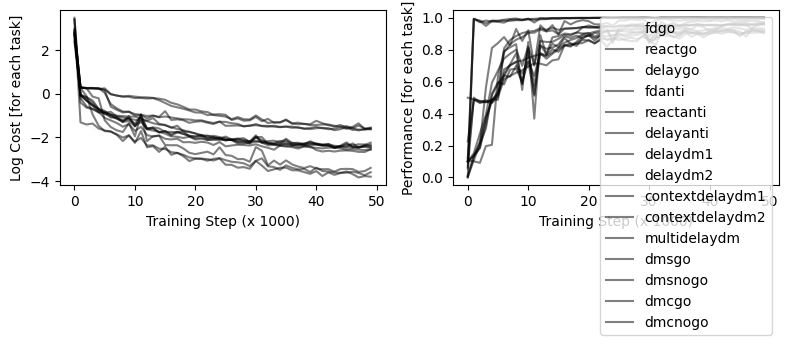

In [9]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

plot_training_history(m,hparams['rule_trains'])

In [10]:
max_d = 2.5
sparsity_threshold = .15
x_ind_counter = 0
ax1_xticks = []
method = 'ward'
criterion = 'distance'
all_epochs = ['stim1','stim2','delay1','delay2','go1']

color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z'}

/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_86919/2219129174.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect=mpatches.Rectangle((5+10*(clust_mid-cluster_size[xi]/2),-5),cluster_size[xi]*10,10,
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_86919/2219129174.py:83: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect=mpatches.Rectangle((-5,10+10*(clust_mid-cluster_size[xi]/2)),5,cluster_size[xi]*10,
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:4126: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect=mpatches.Rectangle((ind-.5,yl),rect_height,rect_width,


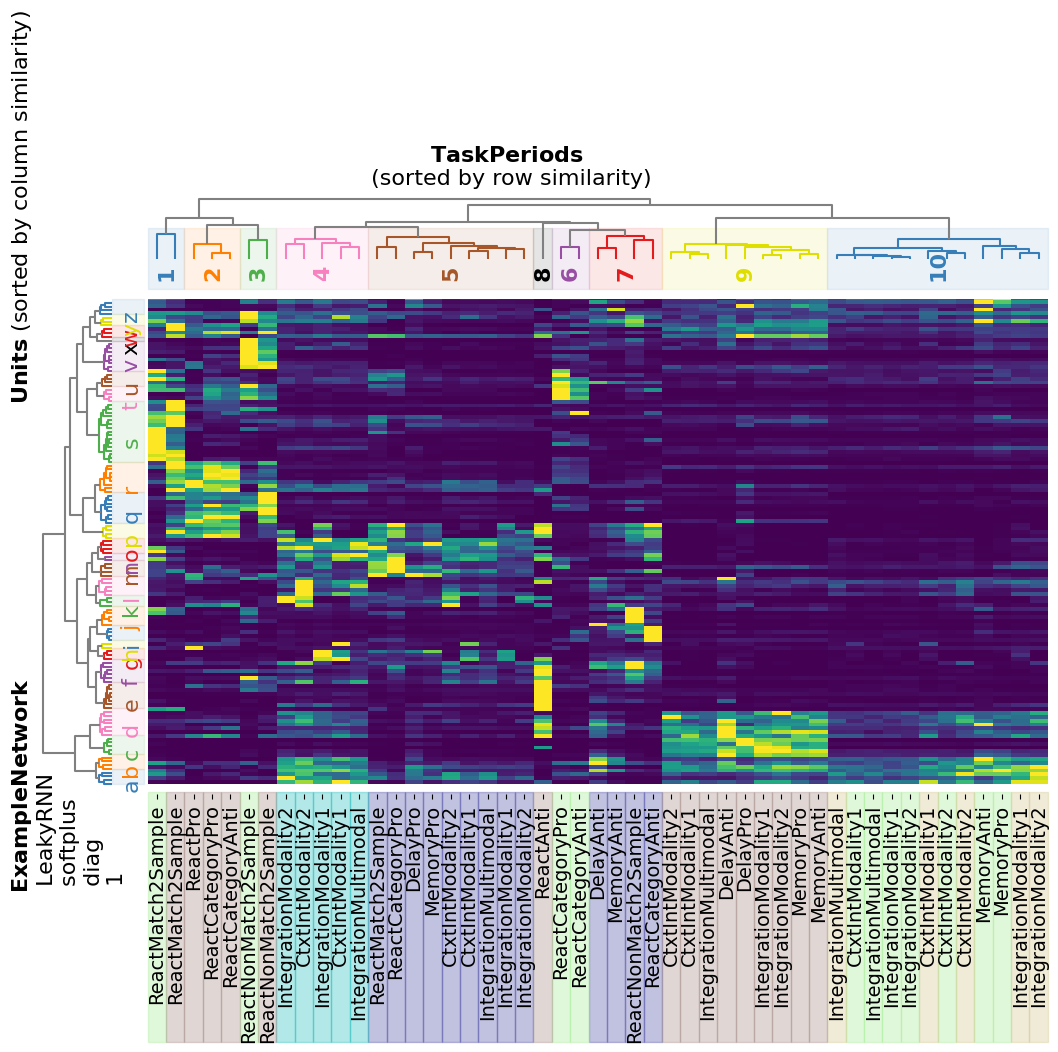

In [11]:
### load master network
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
seed = '1'

label_master = ' '.join([rnn_type,activation,w_init,seed])
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))

# Decode byte strings in feature_names_master (assuming UTF-8 encoding)
feature_names_master = cluster_var['tick_names'].astype(str)  # Convert to strings
feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]

epoch_binary = {}
for e_name in ['delay1','delay2','go1','stim1','stim2']:
    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                            feat_name in feature_names_master]

D = cluster_var['D'].T
feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

feat_order = [feature_names_original.index(s) for i,s in enumerate(cluster_var['tick_names'])]
X = D[:,feat_order]

#visualize atlas for master network
fig = plt.figure(figsize=(18,9))
plt.rcParams.update({'font.size': 16})
legend_done = 0
atlas_width = .55
atlas_height = .55
thresh = 4

axdendro_top = fig.add_axes([.06,atlas_height+.09,atlas_width-.05,.07])
Y = sch.linkage(X.T, method=method)
clusters_top = fcluster(Y, thresh, criterion=criterion)
Z_top = sch.dendrogram(Y, orientation='top',
                   leaf_font_size = 11,color_threshold=thresh,
                          above_threshold_color='gray', labels = clusters_top)

cluster_size,mid_top = make_cluster_midpoint_labels(clusters_top)
for xi in range(len(mid_top)-1):
    if cluster_size[xi]==1:
        c = 'k'
    else:
        color_ind = xi - np.sum(cluster_size[:xi]==1)
        c = color_palette[color_ind%len(color_palette)]
    clust_mid = mid_top[xi]
    rect=mpatches.Rectangle((5+10*(clust_mid-cluster_size[xi]/2),-5),cluster_size[xi]*10,10, 
    fill=True,color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(clust_mid*10,-3,str(clusters_top[int(clust_mid)]),color=c,fontweight='bold',rotation = 90)
    
remove_spines(axdendro_top)
remove_ticks(axdendro_top)
axdendro_top.set_xticks([])

axdendro = fig.add_axes([0,.054,0.04,atlas_height*.98])
Y = sch.linkage(X, method=method)
clusters = fcluster(Y, max_d, criterion=criterion)

Z = sch.dendrogram(Y, orientation='left',
                   leaf_font_size = 11,color_threshold=2.07,
                          above_threshold_color='gray', labels = clusters)

clusters = cluster_var['clusters']

cluster_size, mid = make_cluster_midpoint_labels(clusters)
for xi in range(len(mid)-1):

    if xi>22:
        ci = xi-1
    else:
        ci = xi
    
    c = color_palette[ci%len(color_palette)]
    
    if xi==22:
        c = 'k'
        
    clust_mid = mid[xi]
    rect=mpatches.Rectangle((-5,10+10*(clust_mid-cluster_size[xi]/2)),5,cluster_size[xi]*10, 
    fill=True,
    color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(-1.5,10*clust_mid-20,alphabet[clusters[int(clust_mid)]],color =c,rotation = 90)
    
remove_spines(axdendro)
remove_ticks(axdendro)
axdendro.set_xticks([])

axmatrix = fig.add_axes([.06,0.045,atlas_width-.05,atlas_height])#fig.add_subplot(1,2,1)
index_top = Z['leaves']
X = X[index_top,:]
plt.imshow(X[-1:0:-1,:],cmap= 'viridis', aspect='auto')

len_te = len(feature_names_labels)
axmatrix.set_xticks(range(len_te))
task_labels = [task_name_dict[feat] for feat in feature_names_labels]
axmatrix.set_xticklabels(task_labels,fontsize = 14, rotation =90,ha = 'center')
plot_epoch_rects(axmatrix,epoch_binary,all_epochs,which_axes = 'y', rect_height = 1, rect_width = 65)

plt.text(-8,len(X)/5,r"$\bf{Units}$"+' (sorted by column similarity)',rotation = 90)
plt.text(-8,1.2*len(X),r"$\bf{Example Network}$"+ ' \n '+' \n '.join(label_master.split()),rotation = 90)
axmatrix.set_xlabel(r"$\bf{Task Periods}$"+ ' \n (sorted by row similarity)')
axmatrix.xaxis.set_label_coords(.4, 1.31)
remove_spines(axmatrix)
axmatrix.set_yticks([])
plt.ylim((len(X)+1,0))

figname = os.path.join('atlas_'+label_master+'.pdf')
plt.savefig(os.path.join(figpath,figname),bbox_inches = 'tight')

plt.show()

In [20]:
import csv

# Save X as a CSV file
with open("X.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    
    # Write a header row with feature names (optional for clarity)
    if feature_names_original:  # Check if feature names are available
        writer.writerow(feature_names_original)  # Write feature names as header
    
    # Write the data from X
    writer.writerows(X)

# Save feat_order as a CSV file (without any header)
with open(os.path.join(figpath, "fig3a.csv"), "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(feat_order)
